In [31]:
import subprocess
import os
from pathlib import Path
import gdxpds
import pandas as pd
import matplotlib.pyplot as plt
import re
from gdxpds import to_dataframes
import numpy as np
import seaborn as sns
import itertools

In [32]:
results_folder = Path("Results")

def extract_results(selected_files = None):
    """
    For each (scen, data, stor) in selected_files, load the corresponding file and return
    a list of OrderedDicts (from to_dataframes), in the same order as selected_files.
    """
    print("Loading results...")
    results = []
    results_dir = os.path.join(os.getcwd(), results_folder)
    os.makedirs(results_dir, exist_ok=True)
    pattern = re.compile(r"results_SCEN(?P<scen>\w+)_DATA(?P<data>\w+)_COST(?P<cost>\w+)_STOR(?P<stor>yes|no)\.gdx")

    file_lookup = {}
    for filename in os.listdir(results_dir):
        match = pattern.match(filename)
        if match:
            key = (match.group("scen"), match.group("data"), match.group("cost"), match.group("stor"))
            file_lookup[key] = os.path.join(results_dir, filename)
    
    if selected_files is not None:
        for selected_file in selected_files:
            selected_file[0] = selected_file[0] + str(selected_file[4]) #adding value to scenario
            selected_file = selected_file[:-1] #removing value access by key
            key = tuple(selected_file)
            if key in file_lookup:
                filename = file_lookup[key]
                print(filename)
                results.append(to_dataframes(filename))
            else:
                print(f"{key} not found")
                

        return results
    else:
        for key, filename in file_lookup.items():
            print(filename)
            results.append(to_dataframes(filename))
        return results  

In [36]:
sns.set_theme(style="whitegrid", font_scale=1.3)
from matplotlib.ticker import MaxNLocator
from collections import OrderedDict

def plot_name(dictList, name, x_col, y_col, target, selected_files, title=None, xlabel=None, ylabel=None):
    dfList = []
    for i in range(0, len(dictList)):
        df = dictList[i][name] #copy
        dfList.append(df) #grab relevant dataframes for each file by variable name
    
    if x_col is None:
        x_col = "YEAR"

    if target != None:
        all_targets = sorted(set().union(*[df[target].unique() for df in dfList]))
        palette = sns.color_palette("tab20", n_colors=len(dfList[0][target].unique()))
        colour_map = dict(zip(all_targets, palette))

    n = len(dfList)
    ncols = 2
    nrows = (n+1)//ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows*5), sharey=True, sharex=True)
    axes = axes.flatten()
    for i,df in enumerate(dfList):
        ax = axes[i]

        if target == None:
            ax.plot(df["YEAR"], df[y_col], label=title, linewidth=2)
        else:
            ######
            if title=="StorageLevelSeasonStart": #treat seasonal plots differently
                df["Year_Season"] = df["YEAR"].astype(str) + "_S" + df["SEASON"].astype(str)
                x_col = "Year_Season"
                x_label = x_col
                df.drop(columns=["SEASON", "YEAR"], inplace=True)
                
            df = df.pivot_table(index=x_col, columns=target, values='Level', aggfunc='sum', fill_value=0)

            
            for col in df.columns:
                if col[:3] == "VIR" or col[:3] == "IMP" or col == "IHC": #remove technologies that we are not interested in
                    continue
                if (df[col] != 0).any():
                    ax.plot(df.index, df[col], label=col, color=colour_map[col], linewidth=2)
            if selected_files[i][2] == "real":
                ax.set_title(f"{title if title else name} - Scenario: {selected_files[i][0]}", fontsize=14)
            else:
                ax.set_title(f"{title if title else name} - Scenario: {selected_files[i][0]}, Cost: {selected_files[i][2]}", fontsize=14)
            ax.set_xlabel(xlabel if xlabel else x_col)
            ax.set_ylabel(ylabel if ylabel else y_col)
            ax.grid(True)
            ax.xaxis.set_major_locator(MaxNLocator(nbins=6))  # Reduce overcrowding on x-axis
            ax.tick_params(axis='x', rotation=45)
        
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    handles, labels = [], []
    for ax in axes.flat:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)

    by_label = OrderedDict(zip(labels, handles))

    # Place legend on the right outside plot
    fig.legend(
        by_label.values(), by_label.keys(),
        loc='center left',
        bbox_to_anchor=(1.01, 0.5),
        borderaxespad=0.,
        frameon=True,
        framealpha=0.6
    )

# Add some padding between plot and legend
    plt.subplots_adjust(right=0.85)

    #handles, labels = axes[0].get_legend_handles_labels()
    #fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=4, frameon=False, framealpha=0.4)


    fig.tight_layout()
    #fig.suptitle(title if title else f"{y_col} vs {x_col}", fontsize=16)
        
    plt.show()

def plot_allusefulcharts(dictList, selected_files, filter=None):
    x_col = "YEAR"
    y_col = "Level"

    TechnologyPlots = ["ProductionByTechnologyAnnual", "ProductionByTechnology", "CapitalInvestment", 
    "UseByTechnologyAnnual","OperatingCost", "RateOfProductionByTechnology", 
    "RateOfTotalActivity", "AnnualTechnologyEmission", "TotalCapacityAnnual"]
    FuelPlots = ["RateOfUse", "Trade", "UseAnnual"]
    StoragePlots = ["NewStorageCapacity", "CapitalInvestmentStorage", "StorageLevelYearStart", "StorageLevelYearFinish", "StorageUpperLimit"]
    EmissionPlots = ["AnnualEmissions"]
    singleplots = ["TotalDiscountedCost"] #no "target" to assign
    seasonplots = ["StorageLevelSeasonStart"]
    
    for t in TechnologyPlots:
        if filter!= None and t not in filter:
            continue
        plot_name(dictList, t, x_col=x_col, y_col=y_col, target="TECHNOLOGY", selected_files=selected_files, title=t)

    for f in FuelPlots:
        if filter != None and f not in filter:
            continue
        plot_name(dictList, f, x_col=x_col, y_col=y_col, target="FUEL", selected_files=selected_files, title=f)

    for s in StoragePlots:
        if filter != None and s not in filter:
            continue
  
        plot_name(dictList, s, x_col=x_col, y_col=y_col, target="STORAGE", selected_files=selected_files, title=s)

    for e in EmissionPlots:
        if filter != None and e not in filter:
            continue

        plot_name(dictList, e, x_col=x_col, y_col=y_col,target="EMISSION", selected_files=selected_files, title=e)

    for single in singleplots:
        if filter != None and single not in filter:
            continue
        plot_name(dictList, single, x_col=x_col, y_col=y_col, target=None, selected_files=selected_files, title=single)

    for seasonplot in seasonplots:
        if filter != None and seasonplot not in filter:
            continue
        
        plot_name(dictList, seasonplot, target="STORAGE", selected_files=selected_files, y_col=y_col, x_col=x_col, title=seasonplot)



def run_extr_gams(selected_files, solvermode="mip"):
    for file in selected_files:
        scenario, data, cost, storage, value = file
        print(f"Running GAMS for scenario: {scenario}, data: {data}, cost: {cost}, storage: {storage}, value: {value}")
        subprocess.run([
            "gams",
            "osemosys.gms",
            f"--scen={scenario}",
            f"--data={data}",
            f"--cost={cost}",
            f"--storage={storage}",
            f"--value={value}",
            f"--solvermode={solvermode}"], check=True)
    
    res = extract_results(selected_files)
    return res


In [34]:
#let us compare SSP 1, 2,  - net0by45, ctax
selected_files = [["net0by45", "template", "real", "yes", 0],
                  ["ctax", "template", "real", "yes", 0],
                  ]

dictList = run_extr_gams(selected_files)

Running GAMS for scenario: net0by45, data: template, cost: real, storage: yes, value: 0
--- Job osemosys.gms Start 05/20/25 17:06:48 49.2.0 9b2b0844 DAX-DAC arm 64bit/macOS
--- Applying:
    /Library/Frameworks/GAMS.framework/Versions/49/Resources/gmsprmun.txt
--- GAMS Parameters defined
    Input /Users/hugosmart/Documents/Github/Hy-run/osemosys.gms
    ScrDir /Users/hugosmart/Documents/Github/Hy-run/225a/
    SysDir /Library/Frameworks/GAMS.framework/Versions/49/Resources/
    --scen net0by45
    --data template
    --cost real
    --storage yes
    --value 0
    --solvermode mip
Licensee: Massimo Tavoni                                 G250226+0003Ac-GEN
          Fondazione CMCC                                           DCE4109
          225a/gamslice.dat
          node:56901401 mem:8 cores:8 ipport:63224 v:2                     
          Course license for use within the course and related course work
          The expiration date of time-limited license is Sep 24, 2025
System inf

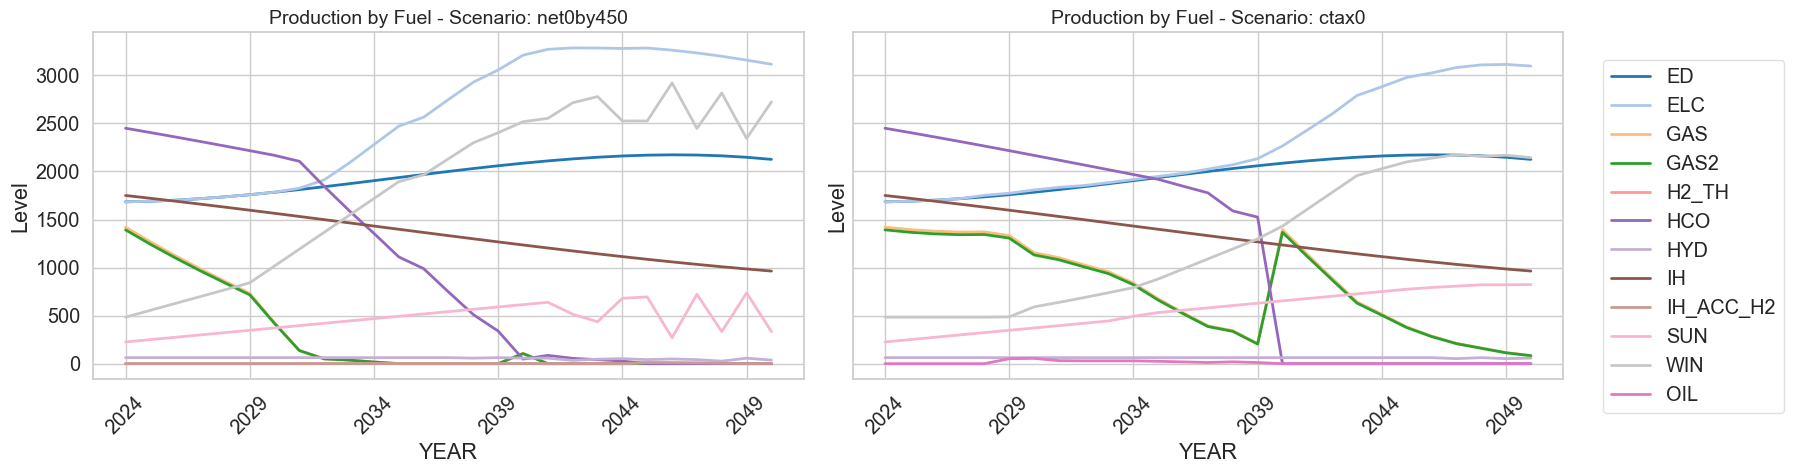

In [38]:
plot_name(dictList, "Production", x_col="YEAR", y_col="Level", target="FUEL", selected_files=selected_files, title="Production by Fuel")

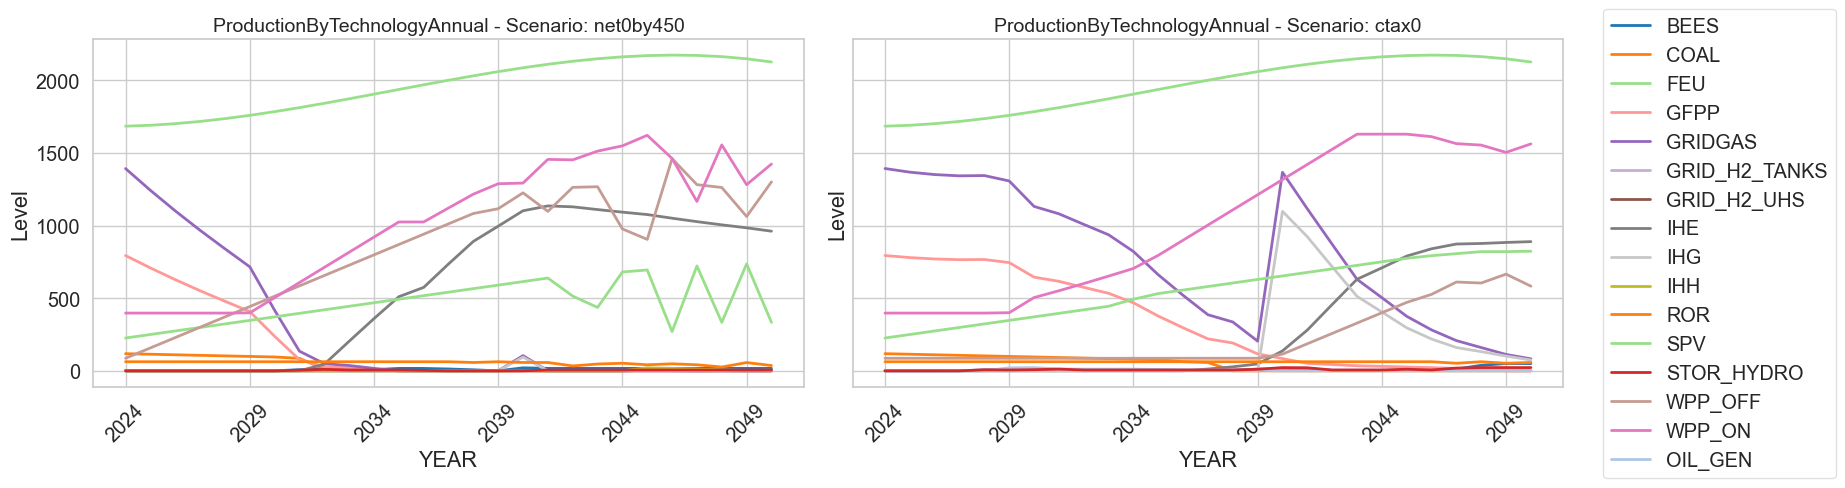

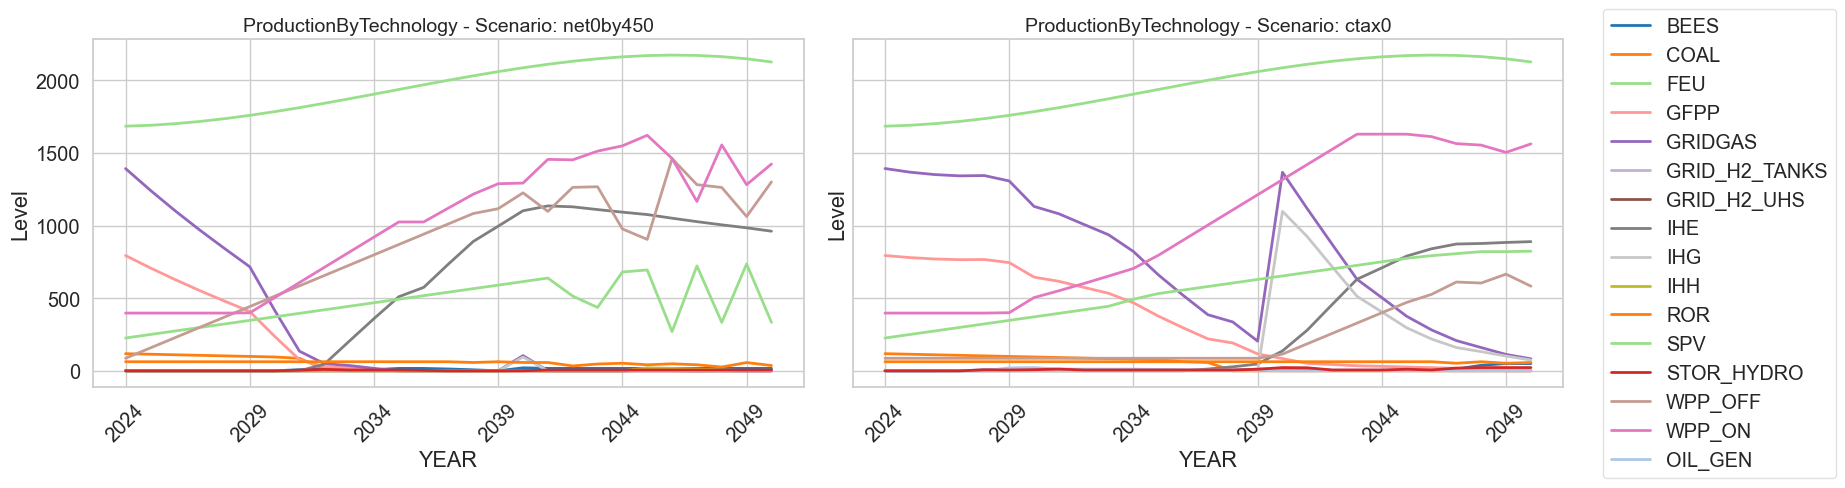

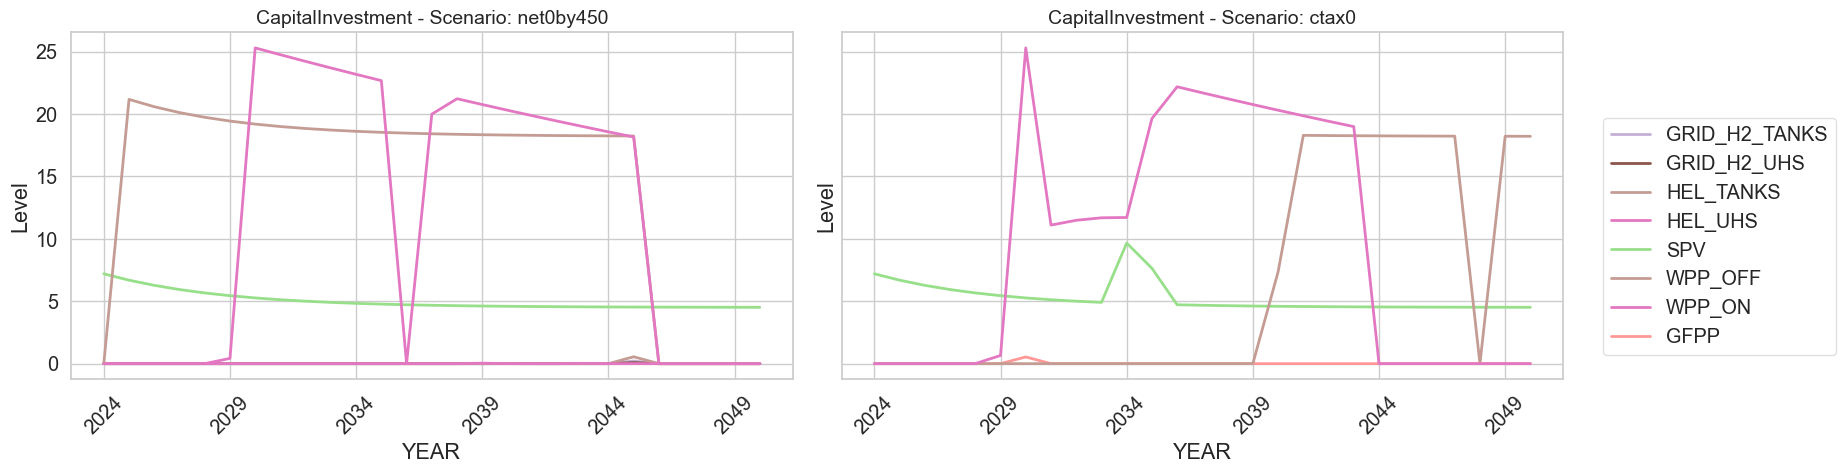

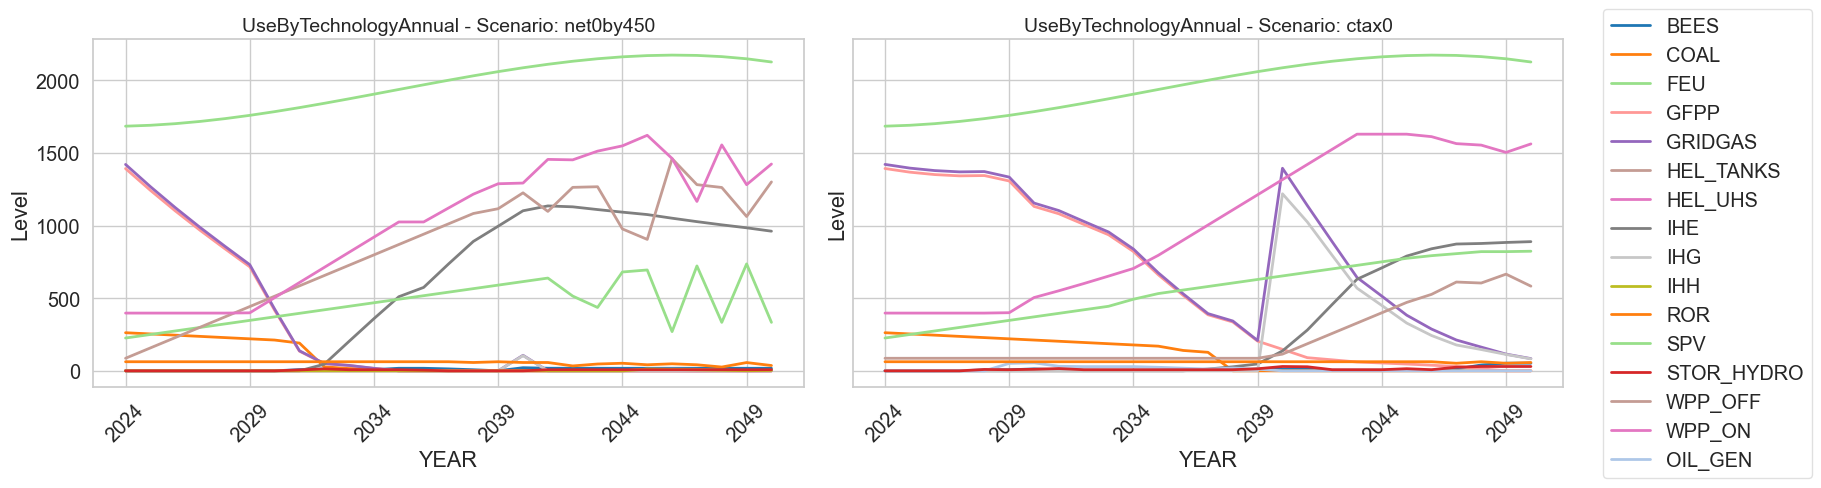

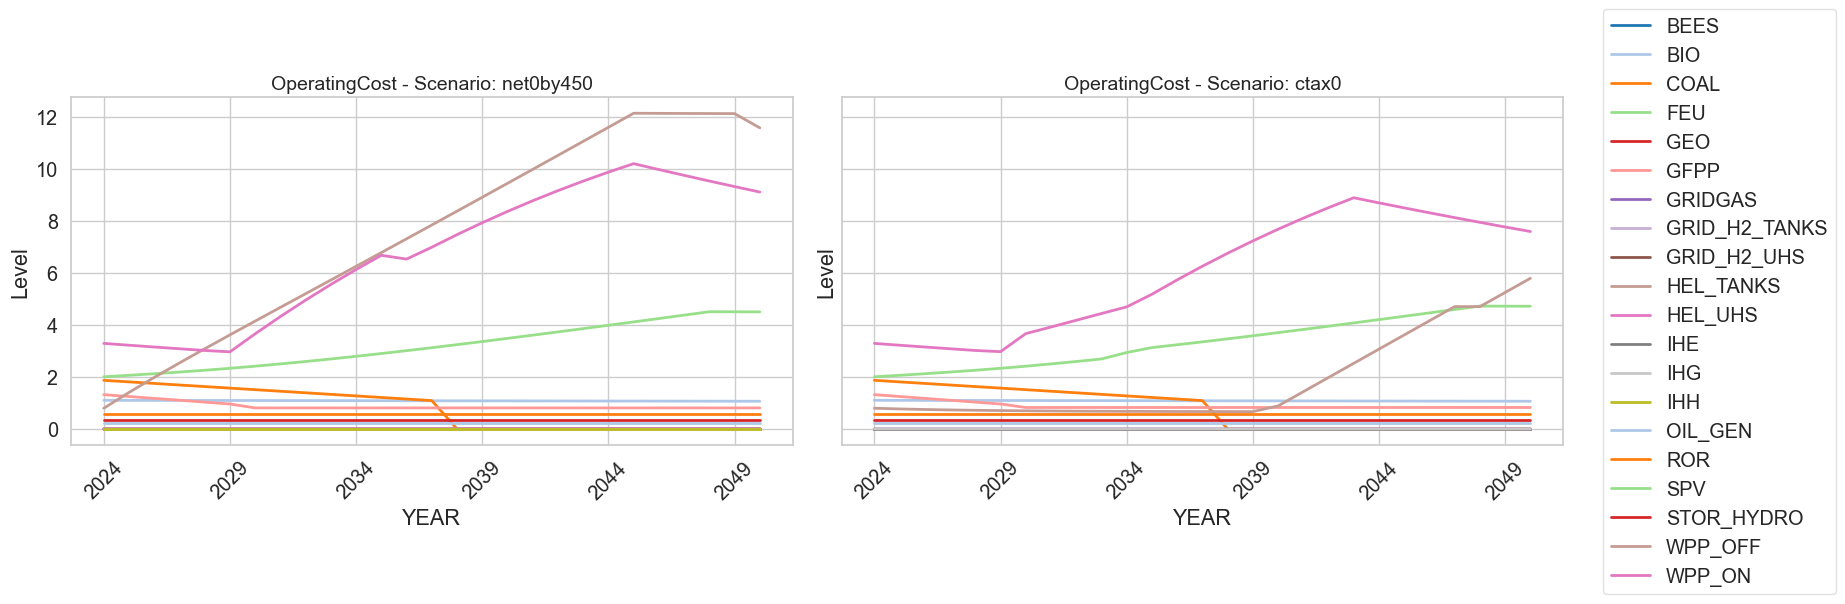

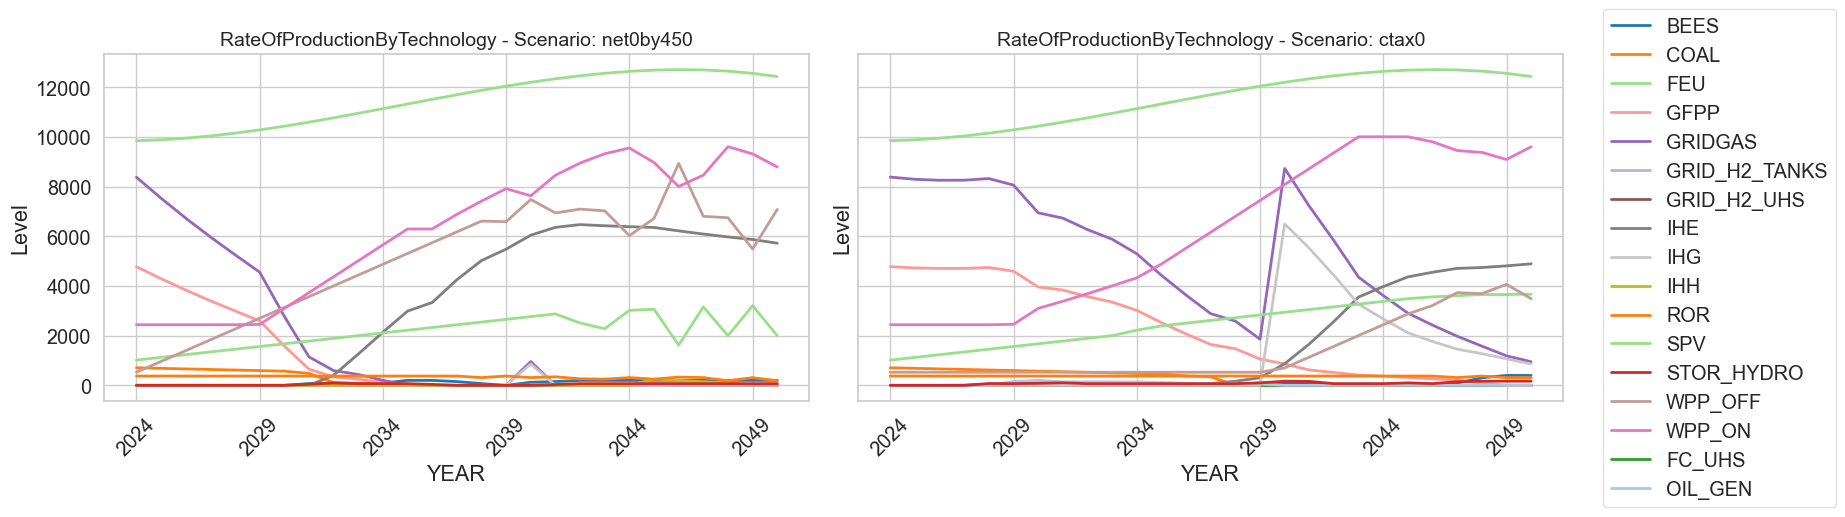

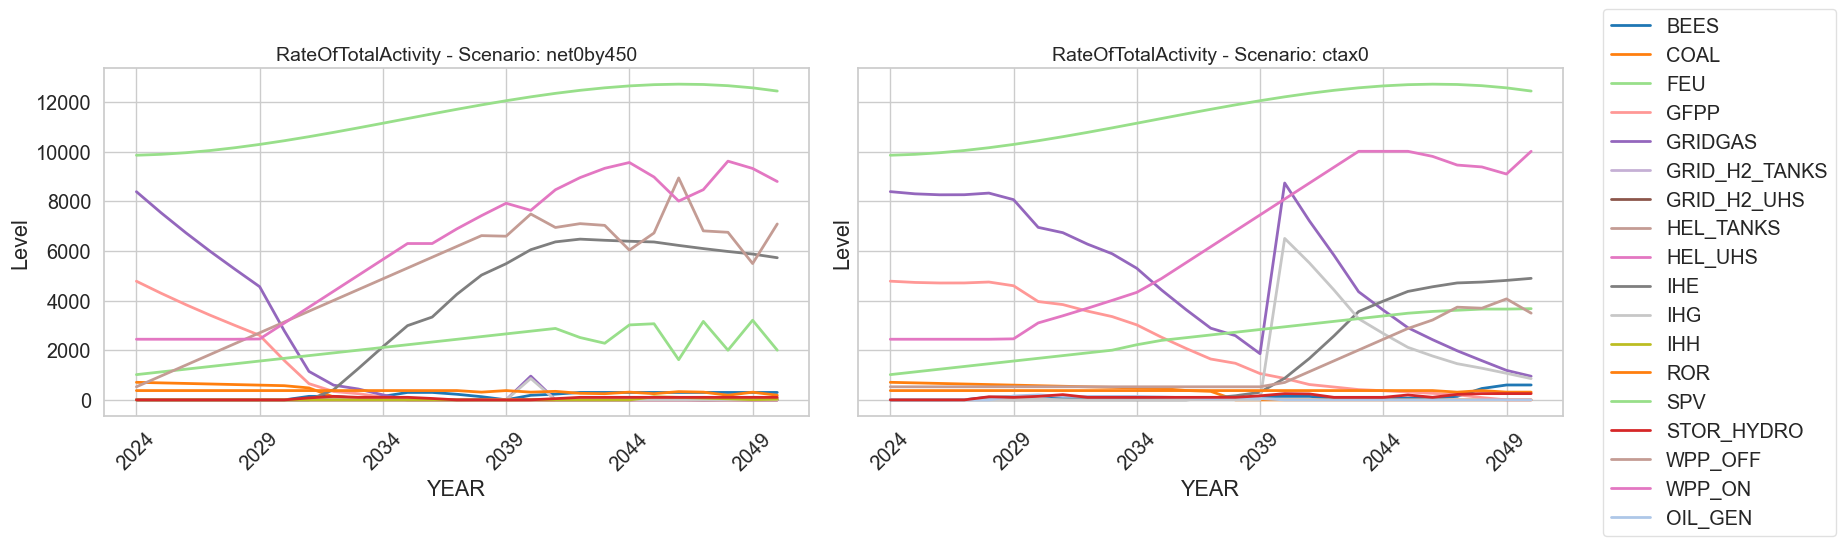

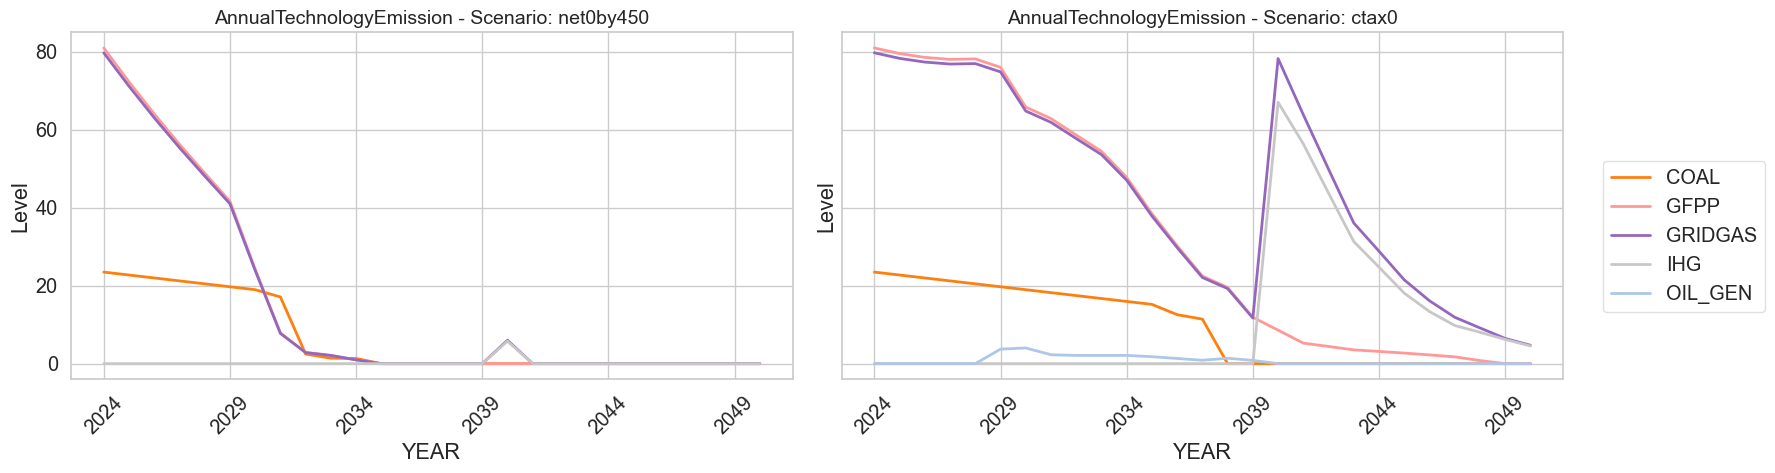

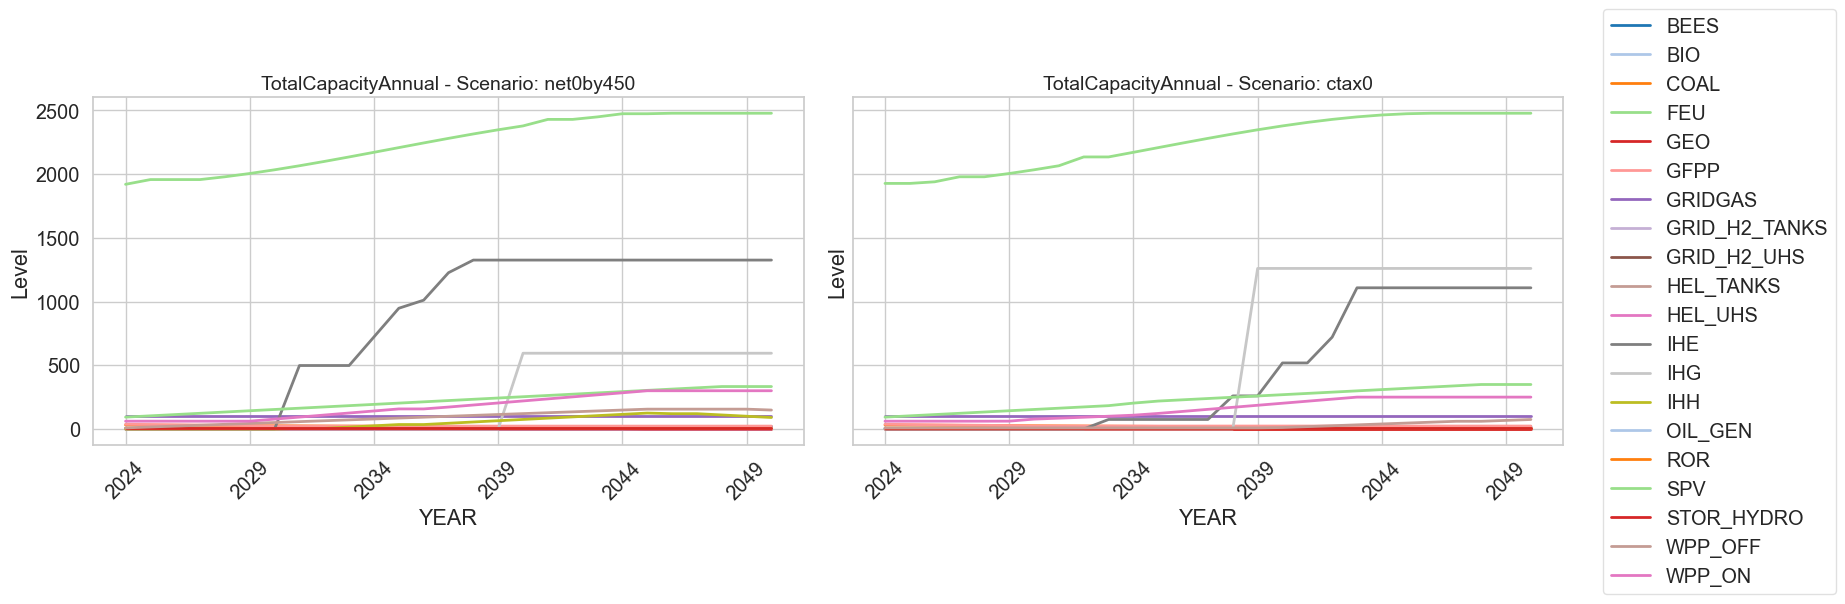

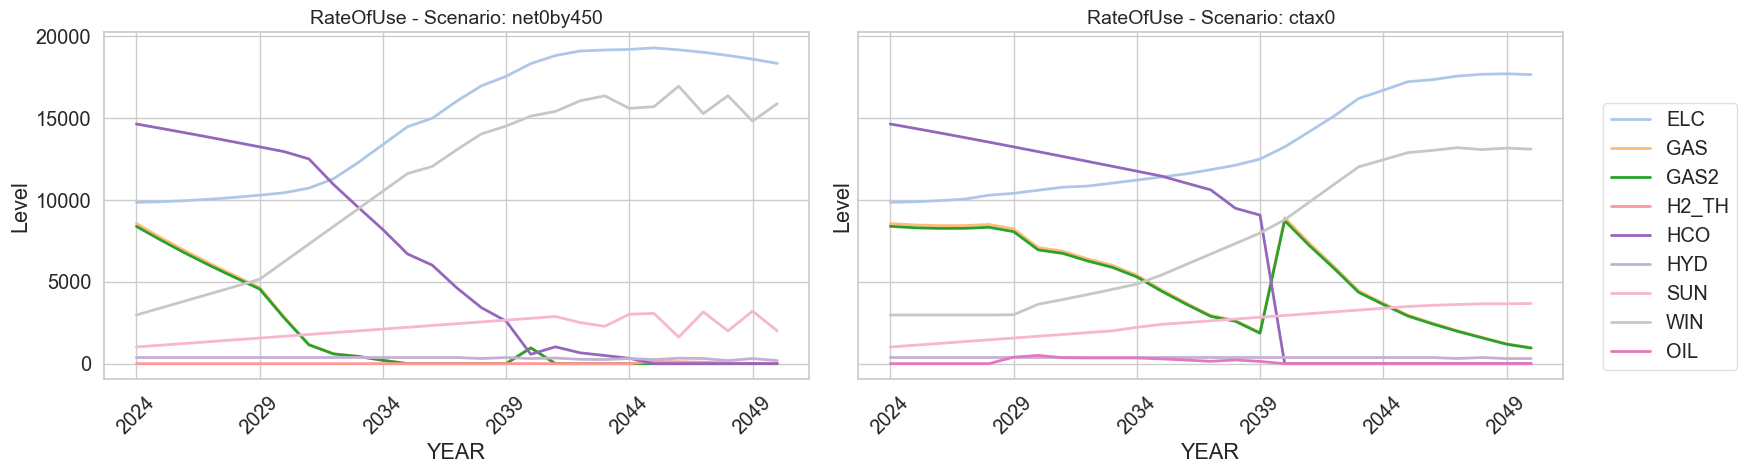

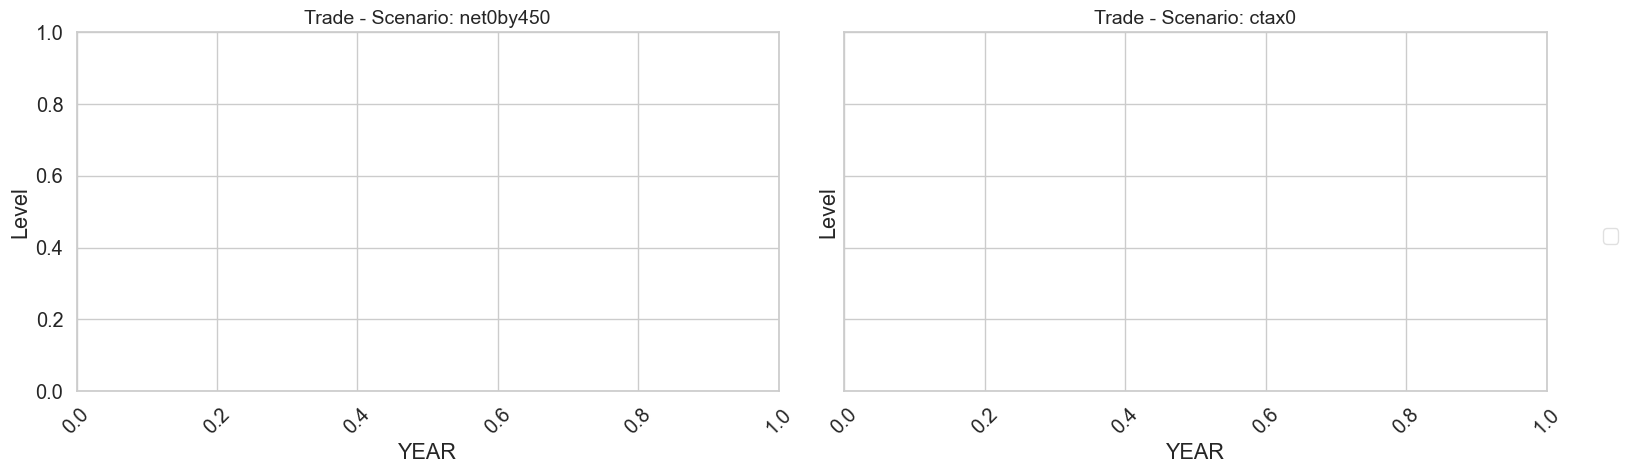

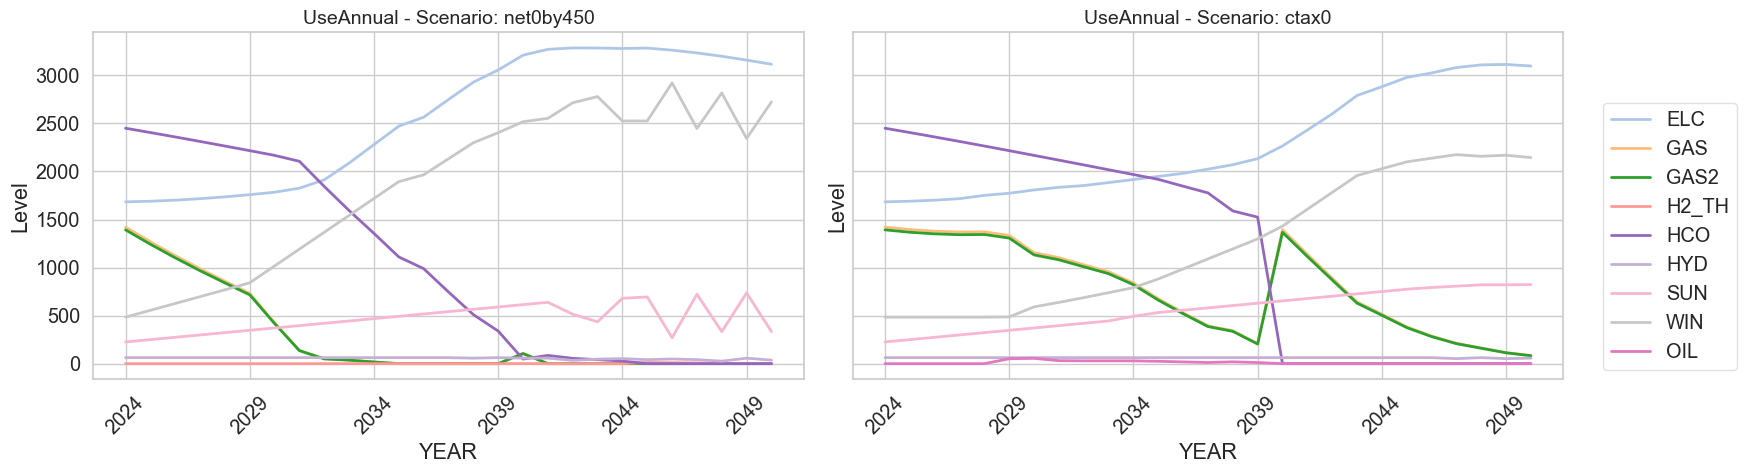

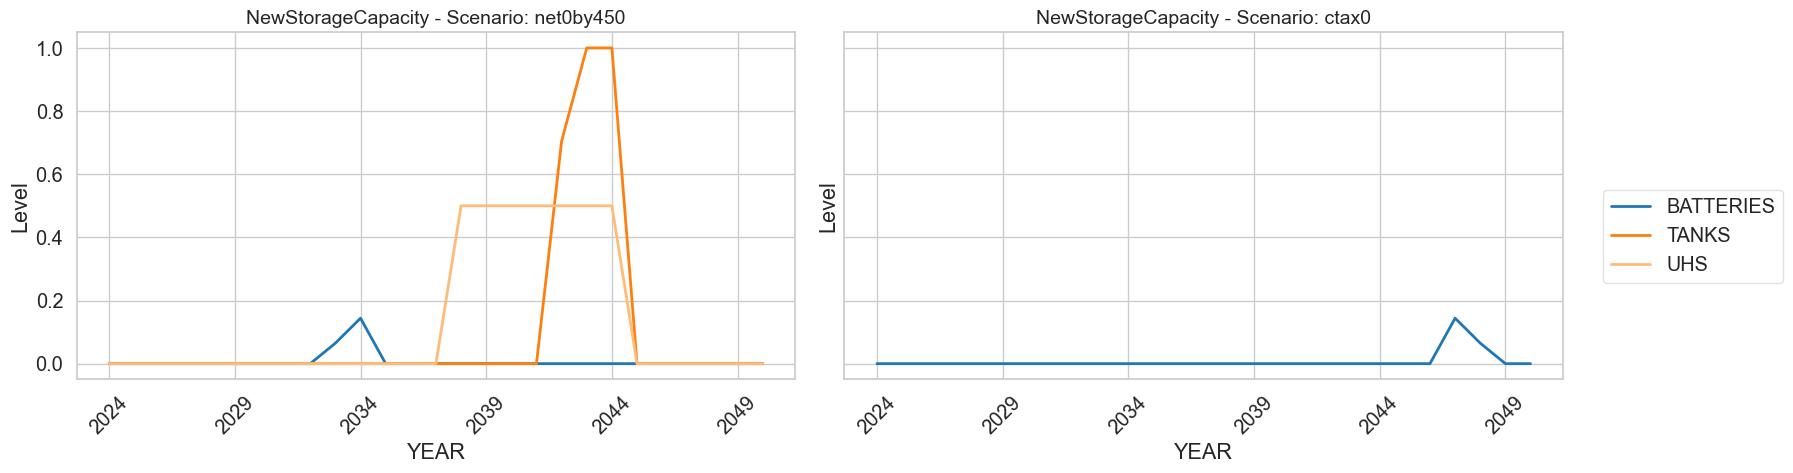

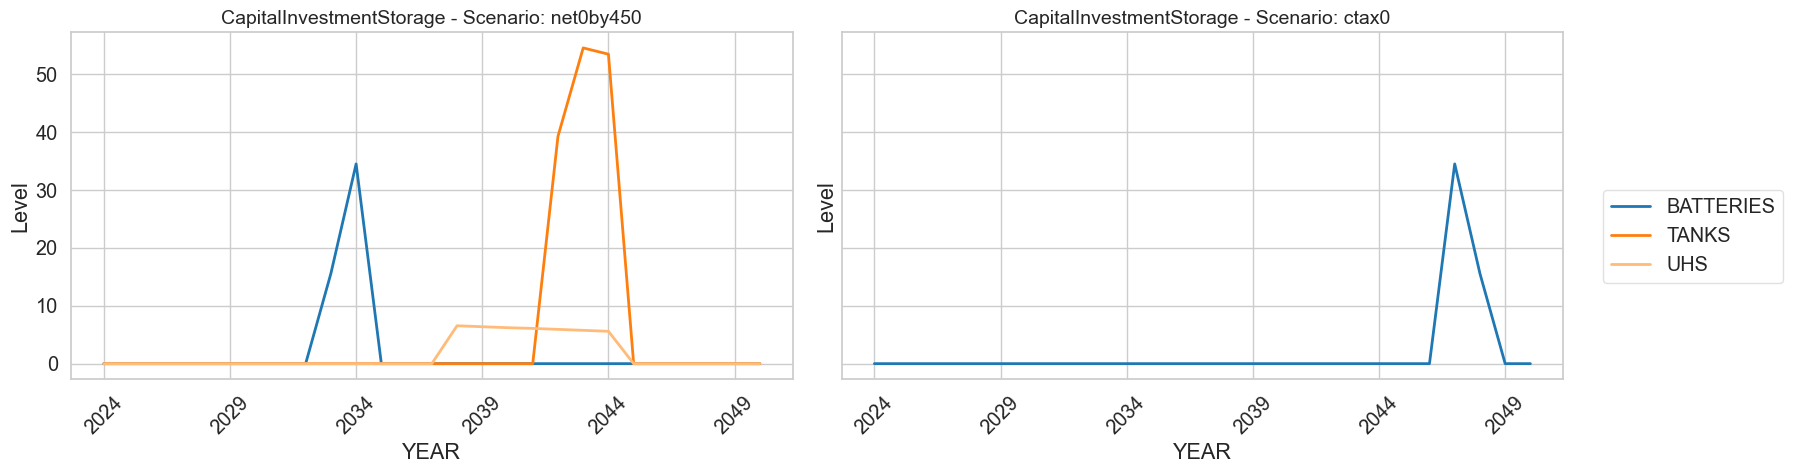

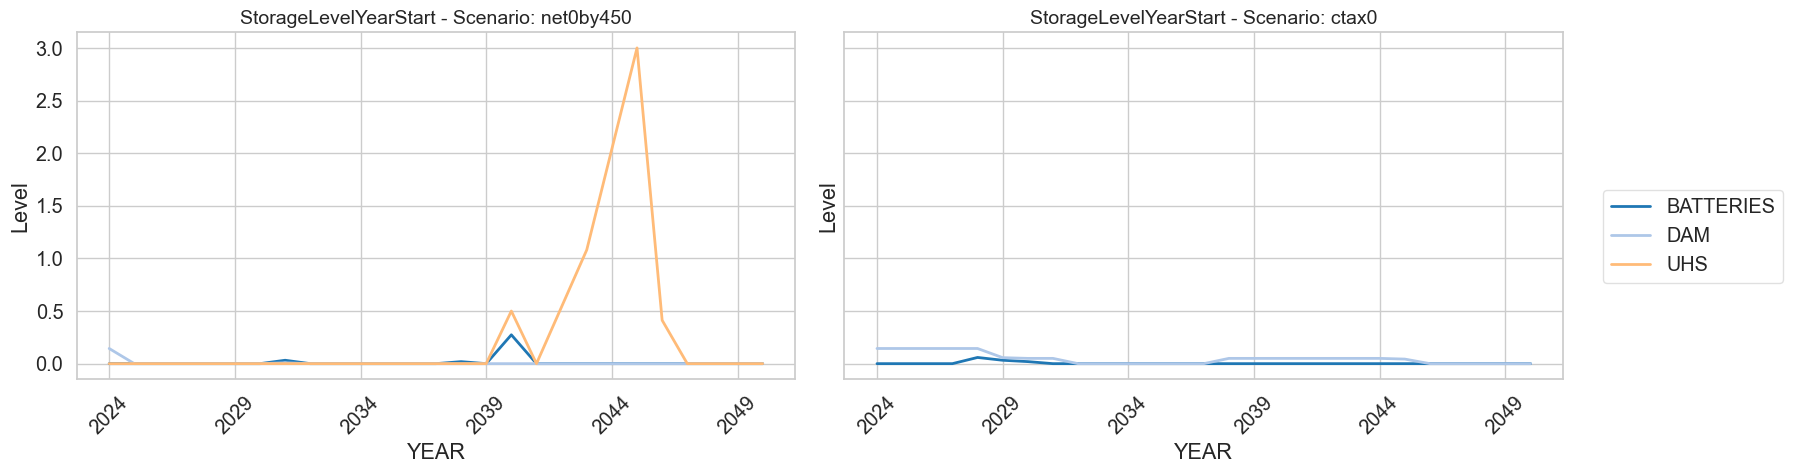

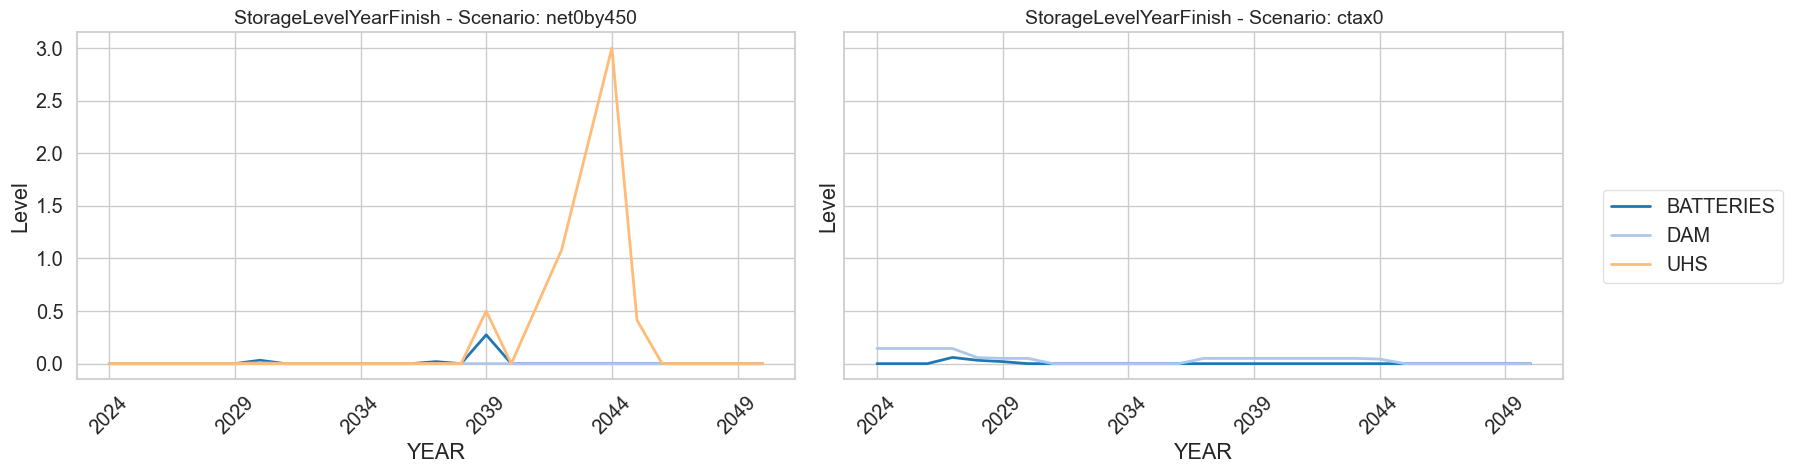

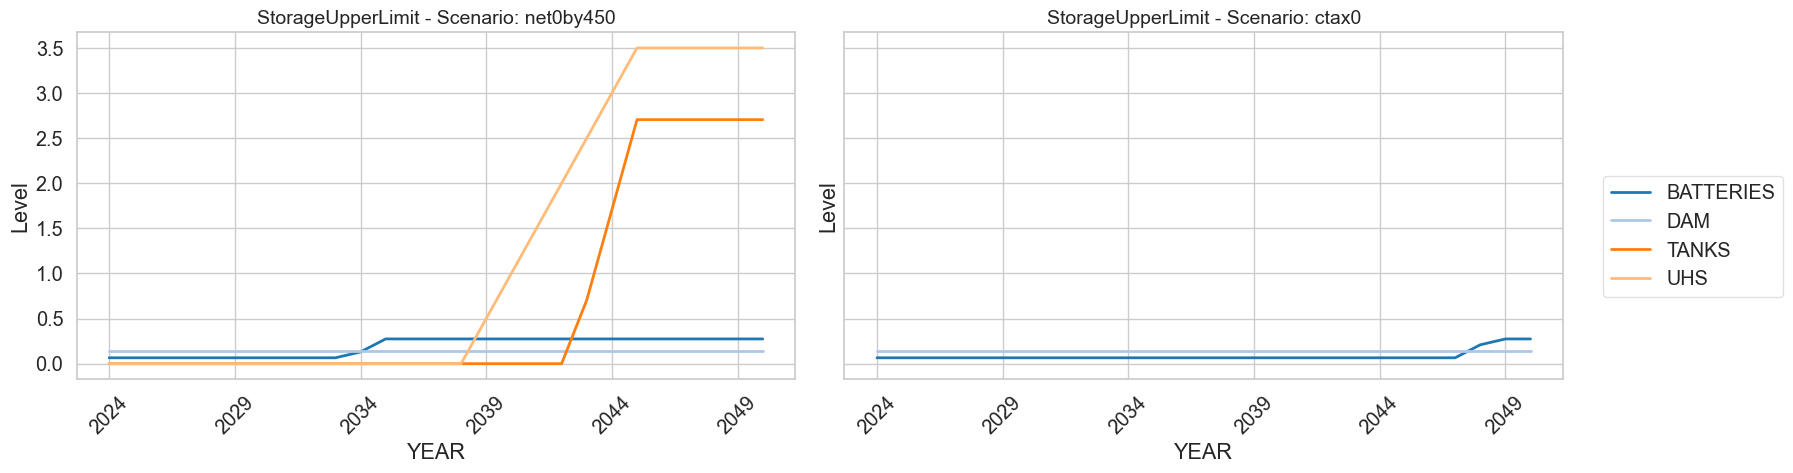

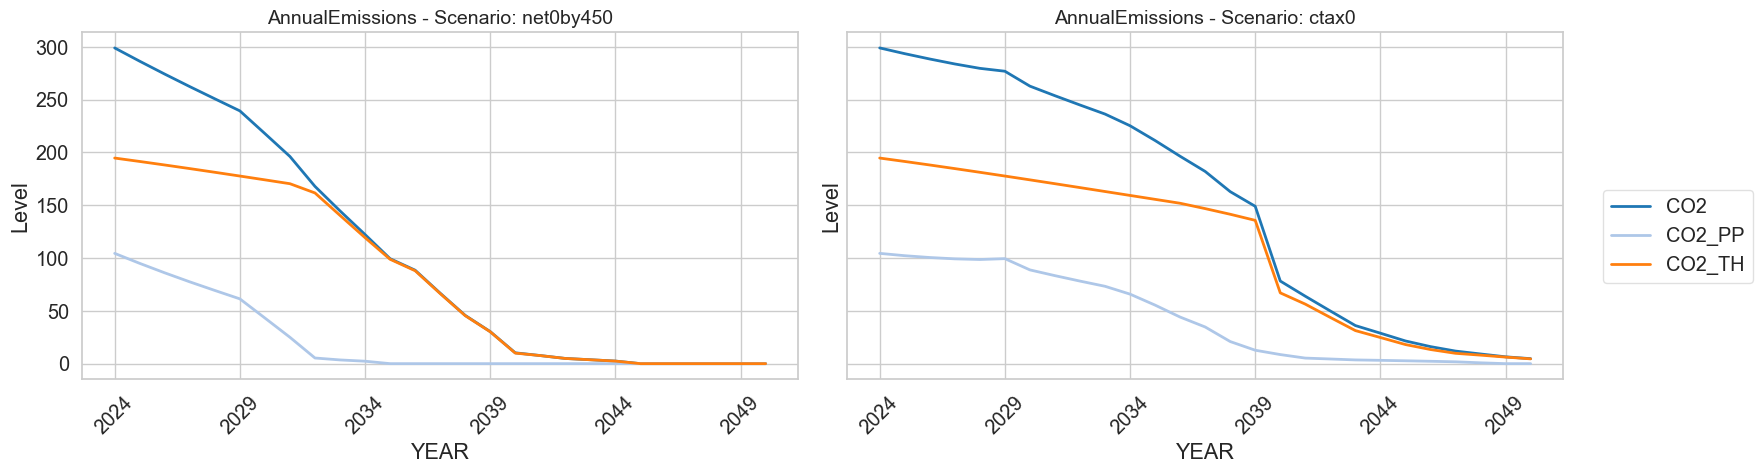

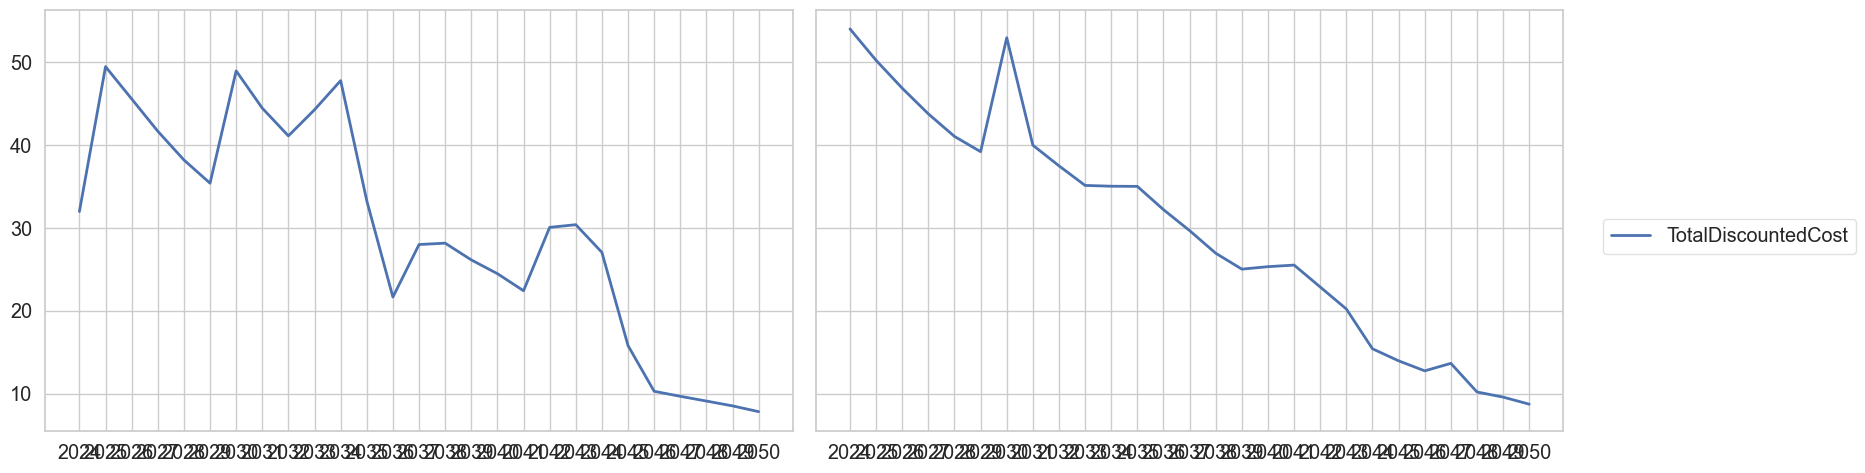

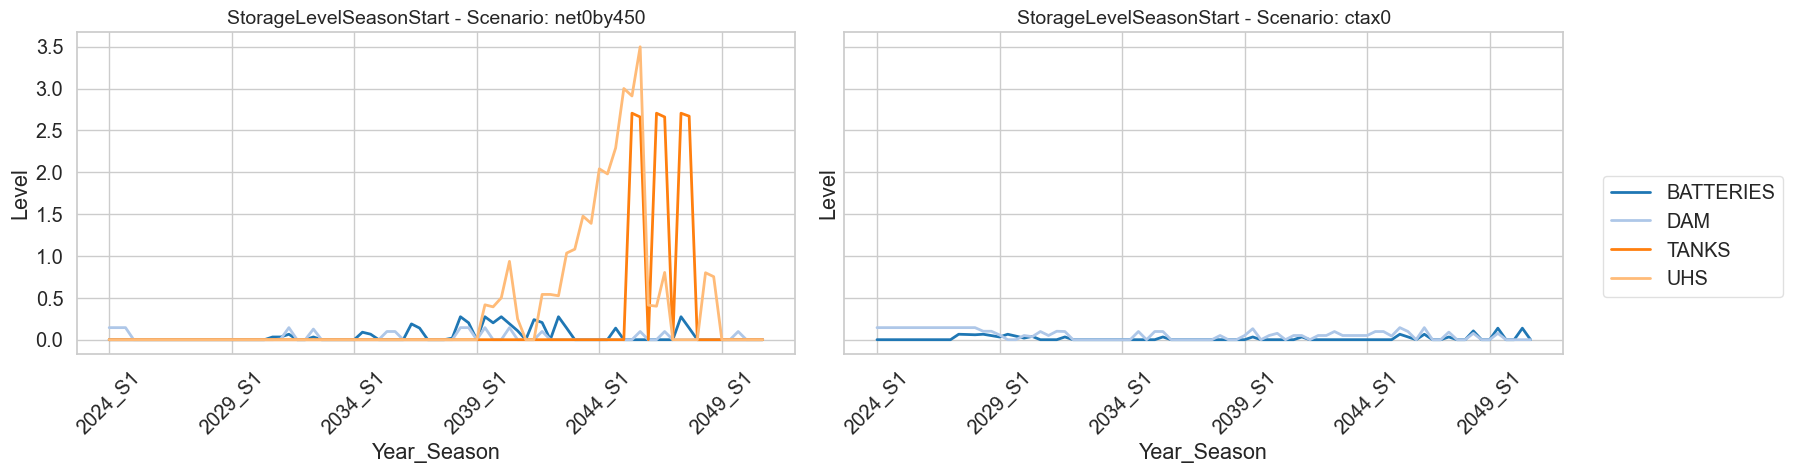

In [35]:
plot_allusefulcharts(dictList, selected_files)